# **A Neural Probabilistic Language Model**
From a 2003 paper - journal of Machine Learning Research

- each word is passed to a 30 neurons structure --> thus a 3 words are passed to 90 neurons
- each work is indexed from 0 to 16999
- then there is 

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [1]:
words = open('_inputs/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# Building the Vocabulary of the characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
print(stoi)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [4]:
# building the dataset

block_size = 3 # context length: how many characters to take to predcit the next one
X, Y = [], [] # X are the inputs, Y are the labels

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

# the dim is the length of the X tensor
dim = len(X)

print(X.shape, Y.shape)

torch.Size([228146, 3]) torch.Size([228146])


In [5]:
X[:5]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])

Being now more ordered:

In [ ]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn(27, 2, generator=g)
W1 = torch.randn(6, 100, generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn(100, 27, generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [22]:
for p in parameters:
    p.requires_grad = True

In [20]:
for _ in range(10000):
    #mini-batch
    ix = torch.randint(0, X.shape[0], (32,)) # understand why 32

    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 6) @ (6, 100) + (100,) --> (32, 100)
    logits = h @ W2 + b2 # (32, 100) @ (100, 27) + (27,) --> (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    for p in parameters:
        p.data -= 0.1 * p.grad

print(loss.item())

2.5072453022003174


In [ ]:
# if I use mini-batches, I have to compute the loss on the aggregate
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # here you lock the second dimension to be 6 and PyTorch will infer the first dimension
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4922, grad_fn=<NllLossBackward0>)

## **How Do I find the right Learning Rate**

In [23]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs[:10]

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011])

In [24]:
lris = []
lossis = []
for i in range(1000):
    #mini-batch
    ix = torch.randint(0, X.shape[0], (32,)) # understand why 32

    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = lrs[i]

    for p in parameters:
        p.data -= lr * p.grad

    lris.append(lr)
    lossis.append(loss.item())

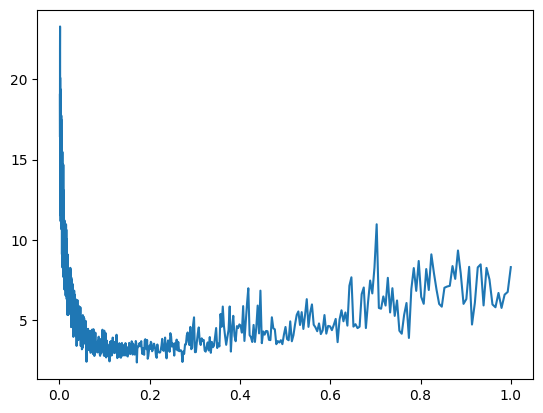

In [ ]:
plt.plot(lris, lossis) # hehe ce lho fatta

In [ ]:
# training, split, dev/validation, test
# 80%, 10%, 10%